In [1]:
import albumentations as A
import torch
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2

from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.object_detection.constants.schema import DetectorContext
from torchlake.common.datasets.voc import VOCDetectionFromCSV, VOCDetectionFromLMDB
from torchlake.object_detection.models.ssd import SSD, MultiBoxLoss
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.object_detection.utils.plot import draw_pred
from torchlake.object_detection.utils.train import collate_fn
from torchlake.common.controller.trainer import DoNothingTrainer

In [2]:
import matplotlib.pyplot as plt
from pathlib import Path

# setting

In [3]:
artifact_path = Path('../../artifacts/ssd')
artifact_path.mkdir(exist_ok=True)

In [4]:
data_path = Path("../../data/VOCdevkit")

In [5]:
NUM_CLASS = len(VOC_CLASS_NAMES)
NUM_ANCHORS = [4, 6, 6, 6, 4, 4]

In [6]:
CONTEXT = DetectorContext(
    detector_name="ssd",
    dataset="VOC",
    device="cuda:0",
    num_classes=NUM_CLASS,
    num_anchors=NUM_ANCHORS,
    anchors_path=artifact_path.joinpath("anchors.txt").as_posix(),
)

# data

In [7]:
BATCH_SIZE = 32

In [8]:
IMAGE_SIZE = 300  # TODO: 512

In [9]:
transform = A.Compose(
    [
        A.ColorJitter(p=0.5),
        A.HorizontalFlip(p=0.5),
        # A.ShiftScaleRotate(p=0.5, rotate_limit=0),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        # A.augmentations.geometric.resize.SmallestMaxSize(IMAGE_SIZE),
        # A.RandomSizedBBoxSafeCrop(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(
        format="yolo",
        # min_area=1024,
        # min_visibility=0.3,
    ),
)

In [10]:
# train_dataset = VOCDetectionFromCSV(
#     data_path,
#     data_path.joinpath("voc_trainval.csv"),
#     transform=transform,
# )

In [11]:
# linux, lmdb can run throught dataset in 2s (was 1.5m)
# but transformation takes 48s
# loader takes 1.5m
# train epoch still takes at least 4m
# the device is ssd

train_dataset = VOCDetectionFromLMDB(
    "/voc",
    transform=transform,
)

In [12]:
for x, y in train_dataset:
    print(x.shape, len(y))
    break

torch.Size([3, 300, 300]) 1


In [13]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    # num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [14]:
for x, y in train_loader:
    print(x.shape, len(y))
    break

torch.Size([32, 3, 300, 300]) 32


In [15]:
# for _, y in train_loader:
#     for ele in y:
#         assert len(ele) > 0, ele

# model

In [16]:
# if anchors does not exist
if not Path(CONTEXT.anchors_path).exists():
    from torchlake.object_detection.models.ssd import PriorBox, save_anchors
    box = PriorBox()
    anchors = box.build_anchors()
    save_anchors(CONTEXT.anchors_path, anchors)

In [17]:
model = SSD(CONTEXT, trainable=False).to(CONTEXT.device)

In [18]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
SSD                                                --
├─Backbone: 1-1                                    --
│    └─VGGFeatureExtractor: 2-1                    --
│    │    └─Sequential: 3-1                        22,943,424
│    │    └─ImageNetNormalization: 3-2             --
│    └─L2Norm: 2-2                                 512
├─ModuleList: 1-2                                  --
│    └─RegHead: 2-3                                --
│    │    └─Conv2d: 3-3                            460,900
│    └─RegHead: 2-4                                --
│    │    └─Conv2d: 3-4                            1,382,550
│    └─RegHead: 2-5                                --
│    │    └─Conv2d: 3-5                            691,350
│    └─RegHead: 2-6                                --
│    │    └─Conv2d: 3-6                            345,750
│    └─RegHead: 2-7                                --
│    │    └─Conv2d: 3-7                       

# train

In [19]:
EPOCH = 10

In [20]:
trainer = DoNothingTrainer(EPOCH, CONTEXT.device)

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = MultiBoxLoss(CONTEXT)

In [22]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [26]:
training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler) 

100%|██████████| 517/517 [04:20<00:00,  1.98it/s]


epoch 1 : 0.30341339330378075


100%|██████████| 517/517 [04:00<00:00,  2.15it/s]


epoch 2 : 0.20662013128601606


100%|██████████| 517/517 [03:30<00:00,  2.46it/s]


epoch 3 : 0.19823461771011353


100%|██████████| 517/517 [03:31<00:00,  2.45it/s]


epoch 4 : 0.19368505379909243


100%|██████████| 517/517 [02:55<00:00,  2.94it/s]


epoch 5 : 0.1912475632110924


100%|██████████| 517/517 [02:46<00:00,  3.10it/s]


epoch 6 : 0.1902138180382247


100%|██████████| 517/517 [02:50<00:00,  3.04it/s]


epoch 7 : 0.1880922198756751


100%|██████████| 517/517 [02:48<00:00,  3.06it/s]


epoch 8 : 0.1750231611774784


100%|██████████| 517/517 [02:49<00:00,  3.05it/s]


epoch 9 : 0.17199005526661643


100%|██████████| 517/517 [03:04<00:00,  2.80it/s]

epoch 10 : 0.17058874879976305


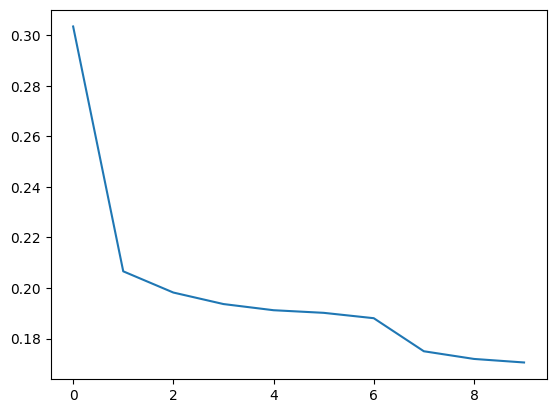

In [27]:
plt.plot(training_loss)

In [92]:
model_path = artifact_path / f'ssd.{IMAGE_SIZE}{".jointly." if model.trainable else "."}10.pth'

In [93]:
model_path

PosixPath('../../artifacts/ssd/ssd.300.10.pth')

In [94]:
torch.save(model.state_dict(), model_path)

In [95]:
get_file_size(model_path)

'100.29MiB'

In [19]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>

# inference

In [28]:
from tqdm import tqdm
from torchlake.object_detection.models.ssd.decode import Decoder
from torchlake.object_detection.configs.schema import InferenceCfg
from torchlake.object_detection.controller.predictor import Predictor

In [29]:
decoder = Decoder(CONTEXT)
inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.3, NMS_THRESH=0.5)

In [30]:
predictor = Predictor(CONTEXT)
predictor.set_postprocess_cfg(decoder, inferCfg)

In [31]:
test_transform = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ]
)

In [32]:
import numpy as np
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import rand_color_map, plot_grids

In [33]:
color_map = rand_color_map(VOC_CLASS_NAMES)

In [34]:
test_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_test.csv"),
    transform=test_transform,
)

In [35]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    # num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [36]:
model.eval()
with torch.no_grad():
    for img, labels in tqdm(test_loader):
        img = img.to(CONTEXT.device)

        # B, C+1, H, W
        output = predictor.detect_image(model, img, is_batch=True)
        break

  0%|          | 0/154 [00:01<?, ?it/s]


In [37]:
placeholder = []
for im, o in zip(img, output):
    overlay = img_tensor_to_np(im, 255, np.uint8)
    draw_pred(
        overlay,
        o,
        class_names=VOC_CLASS_NAMES,
        class_colors=color_map,
    )
    placeholder.append(overlay)

person: 0.50
tvmonitor: 0.41
person: 0.33
person: 0.51
person: 0.45
sheep: 0.35
sheep: 0.36
bird: 0.52
person: 0.32
person: 0.41
person: 0.45
person: 0.47
person: 0.60
cow: 0.50
diningtable: 0.52
diningtable: 0.64
person: 0.32
person: 0.34
person: 0.30
person: 0.31
person: 0.34
person: 0.41
person: 0.45
tvmonitor: 0.39
person: 0.64
person: 0.40
train: 0.51
train: 0.34
diningtable: 0.36
diningtable: 0.37
diningtable: 0.49
diningtable: 0.35
diningtable: 0.54
diningtable: 0.31
person: 0.30
person: 0.36
tvmonitor: 0.67
cow: 0.34
cow: 0.31
cow: 0.31
bottle: 0.32
cow: 0.45
aeroplane: 0.46
person: 0.53
diningtable: 0.40
motorbike: 0.37
motorbike: 0.31
motorbike: 0.53
motorbike: 0.35
motorbike: 0.56
motorbike: 0.39
horse: 0.53


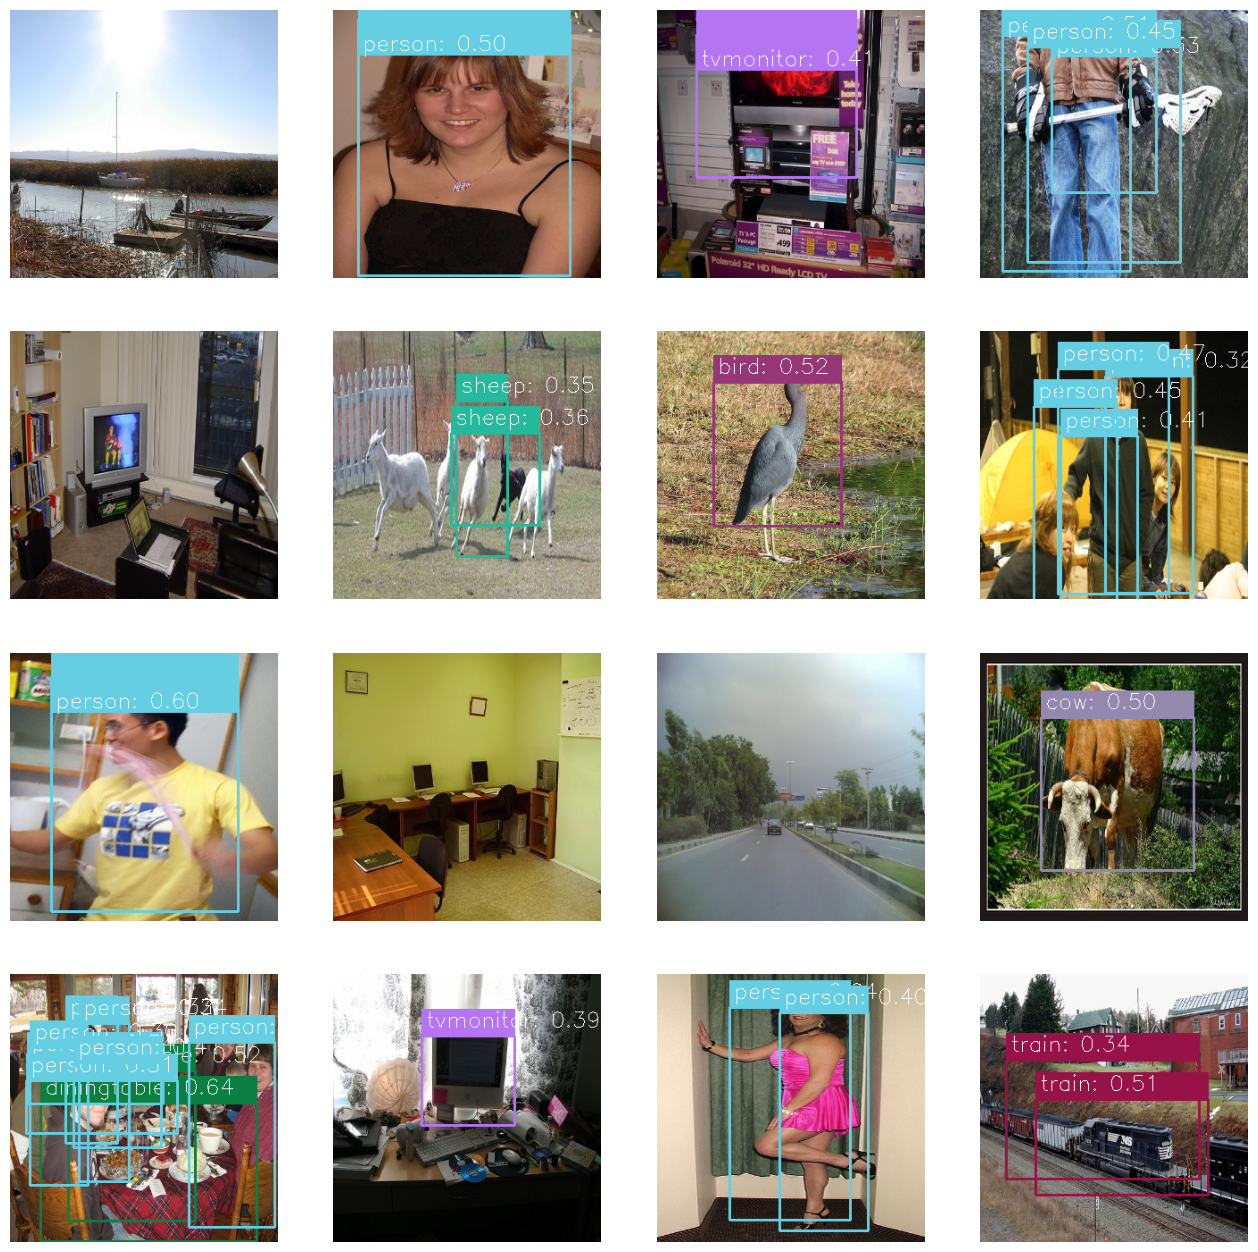

In [38]:
plot_grids(
    placeholder[:16],
    num_row=4,
    num_col=4,
    figsize=(16,16),
)

In [69]:
humans_img = "D://research/pytorch-implementations/data/coco/train2017/000000000165.jpg"
human_img = "D://W/hmm/Screenshot_20240612_091521.jpg"
obj_img = "D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg"

predictor.predict_image_file(
    model,
    [humans_img, human_img, obj_img],
    VOC_CLASS_NAMES,
    color_map,
    test_transform,
    show=False,
    save_dir=artifact_path.as_posix(),
)

person: 0.36
person: 0.51
person: 0.46
person: 0.59
D://research/pytorch-implementations/data/coco/train2017/000000000165.jpg 4
person: 0.49
D://W/hmm/Screenshot_20240612_091521.jpg 1
aeroplane: 0.56
D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg 1


In [ ]:
predictor.predict_video_file(
    model,
    "../../data/movie.mp4",
    VOC_CLASS_NAMES,
    color_map,
    test_transform,
    show=False,
    save_dir=artifact_path.as_posix(),
)

# evaluation

In [24]:
from torchlake.object_detection.models.ssd.decode import Decoder
from torchlake.object_detection.configs.schema import InferenceCfg
from torchlake.object_detection.controller.predictor import Predictor
from torchlake.object_detection.controller.evaluator import Evaluator

In [25]:
decoder = Decoder(CONTEXT)
inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.3, NMS_THRESH=0.5)

In [26]:
predictor = Predictor(CONTEXT)
predictor.set_postprocess_cfg(decoder, inferCfg)

In [27]:
test_transform = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ]
)

In [28]:
test_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_test.csv"),
    transform=test_transform,
)

In [29]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    # num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [30]:
evaluator = Evaluator(CONTEXT)

In [86]:
result_table = evaluator.run(predictor, model, test_loader, VOC_CLASS_NAMES)

100%|██████████| 154/154 [03:39<00:00,  1.42s/it]

       aeroplane   bicycle      bird      boat    bottle       bus       car  \
AP@0.5  0.405151  0.355408  0.287598  0.277474  0.216611  0.224104  0.296577   

             cat     chair       cow  ...       dog     horse motorbike  \
AP@0.5  0.296921  0.234657  0.233015  ...  0.305759  0.311195  0.311845   

          person pottedplant     sheep      sofa     train tvmonitor       all  
AP@0.5  0.283732    0.280515  0.233831  0.279748  0.284201  0.282093  0.284188  

[1 rows x 21 columns]


In [87]:
result_table.T

,AP@0.5
aeroplane,0.405151
bicycle,0.355408
bird,0.287598
boat,0.277474
bottle,0.216611
bus,0.224104
car,0.296577
cat,0.296921
chair,0.234657
cow,0.233015


In [ ]:
for path in artifact_path.joinpath(evaluator.cfg.MODEL.BACKBONE).glob("*.pth"):
    model.load_state_dict(torch.load(path))

    evaluator.run(
        predictor,
        model,
        test_loader,
        VOC_CLASS_NAMES,
        save_dir=artifact_path.as_posix(),
        output_filename=f"{path.stem}.eval.csv",
    )

# extra

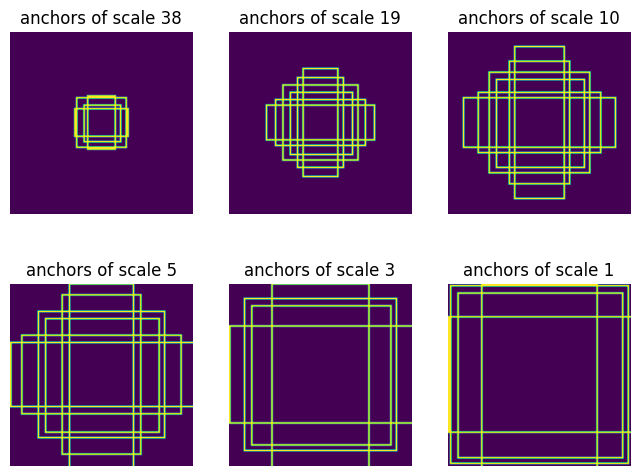

In [14]:
from torchlake.object_detection.utils.plot import draw_anchors
from torchlake.object_detection.models.ssd import load_anchors, PriorBox
from torchlake.common.utils.plot import plot_grids

box = PriorBox()
anchors = load_anchors(artifact_path.joinpath("anchors.txt"))

offset = 0
canvas = []
for num_anchor, feature_size in zip(box.num_anchors, box.feature_sizes):
    canvas.append(draw_anchors(anchors[offset : offset + num_anchor, :]))
    offset += num_anchor * feature_size**2

plot_grids(
    canvas,
    [f"anchors of scale {feature_size}" for feature_size in box.feature_sizes],
    2,
    3,
    figsize=(8,6),
)